In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import os
from load_img.baseimage import PETImage, normalize
import scipy
from scipy.integrate import odeint
from kmeans_segmentation import pca_kmeans_segmentation, fourier_kmeans_segmentation, apply_masks, plot_segments
from utility_functions import sparsifyDynamics, poolData
from skimage.restoration import (denoise_wavelet, estimate_sigma)


In [2]:

from matplotlib import style
style.use('dark_background')


#### Some helpful functions

In [3]:
def disp_segment(seg, ax = None, view_ax = 'y', col_t = 'sum', col_v = 'sum', figsize=(18, 16)):
    ax_ix = {'z':0,'y':1,'x':2,'t':3}[view_ax]
    
    frame = getattr(seg,col_t)(axis=3)
    
    img = getattr(frame,col_v)(axis=ax_ix)
    
    if ax is None:
        fig = plt.figure(figsize=figsize)
        plt.imshow(img,cmap='gray')
        plt.show()
    else:
        ax.imshow(img,cmap='gray')
    

    
    
def combine_segments(segments,to_combine):
    # combine one set of segments in a list of segments
    combined = segments[to_combine[0]]
    for ix in to_combine[1:]:
        combined += segments[ix]
    return [seg for i,seg in enumerate(segments) if i not in to_combine] + [combined]
    
    
def make_combinations(segments,to_combine_list):
    # take list of sets to combine
    ns = segments.copy()
    for tc in to_combine_list:
        ns  = combine_segments(ns,tc)
    return ns


def optimal_linear_trajectory(X,A,times):
    # X should be np.ndarray, each row a state at time t
    # A should be df output by sindy, should be linear
    # times should be times at which we evaluate x(t)
    
    def print_nan(mat):
        print(np.count_nonzero(np.isnan(mat)))
    shape = X.shape
    true_states = X.flatten()
    
    # get transition matrix
    A = A.iloc[:,1:].as_matrix()
    transition_matrices = [scipy.linalg.expm(A*t) for t in times]
    phi = np.concatenate(transition_matrices)
    opt_x0 = np.linalg.inv(phi.T.dot(phi)).dot(phi.T).dot(true_states)
    
    
    # resulting soln
    return phi.dot(opt_x0).reshape(shape)
    
def denoise(img):
    sigma_est = estimate_sigma(img, multichannel=False, average_sigmas=True)
    # Due to clipping in random_noise, the estimate will be a bit smaller than the specified sigma.
    print("Estimated Gaussian noise standard deviation = {}".format(sigma_est))
    print("Denoising...")
    denoised_wavelet = denoise_wavelet(img, sigma=sigma_est, multichannel=False, mode='soft')
    return denoised_wavelet

#### Data from File

In [4]:
data_dir = 'data'
pet_files = [f for f in os.listdir(data_dir) if f.endswith('.pet.img') and not f.startswith('.')]
fname = pet_files[0]
fpath = os.path.join(data_dir,fname)
my_img = PETImage(filepath=fpath)
my_img.load_image()

File dimensions: (128,128,159,40)
Reading image data...


## Segment Image

#### Fourier Segmentation

In [5]:
# Ns = my_img.img_data.shape

# # select the middle z=Ws[0],y=Ws[1],x=Ws[2] prism of each frame
# Ws = (128,60,40)
# roi_lims = [(int((N-W)/2),int((N+W)/2)) for N,W in zip(Ns,Ws)]

# # select options for segmentation and run segmentation
# print('Clustering image voxels...')
# options = {
#     'roi_lims' : roi_lims,
#     'plot' : True,
#     'fig_size' : (18, 16),
#     'nfeatures' : 6,
#     'nclusters' : 20
#     }
# masks, roi = fourier_kmeans_segmentation(my_img,**options)



#### Time series segmentation

In [7]:
Ns = my_img.img_data.shape

# select the middle z=Ws[0],y=Ws[1],x=Ws[2] prism of each frame
Ws = (128,60,40)
roi_lims = [(int((N-W)/2),int((N+W)/2)) for N,W in zip(Ns,Ws)]

# my_img.img_data = denoise(my_img.img_data)

# select options for segmentation and run segmentation
print('Clustering image voxels...')
options = {
    'roi_lims' : roi_lims,
    'figsize' : (18, 16),
    'nfeatures' : 6,
    'nclusters' : 20
    }
masks, roi = pca_kmeans_segmentation(my_img,**options)

# done with original image data
# my_img.unload_image()

Clustering image voxels...
Created 20 masks of image


#### apply masks to original ROI

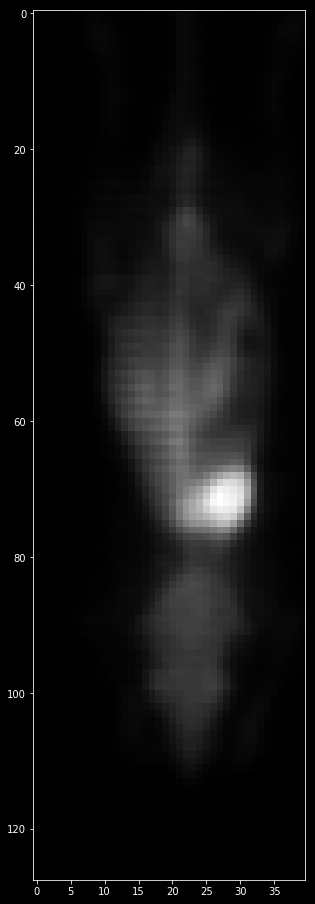

In [8]:
disp_segment(roi)

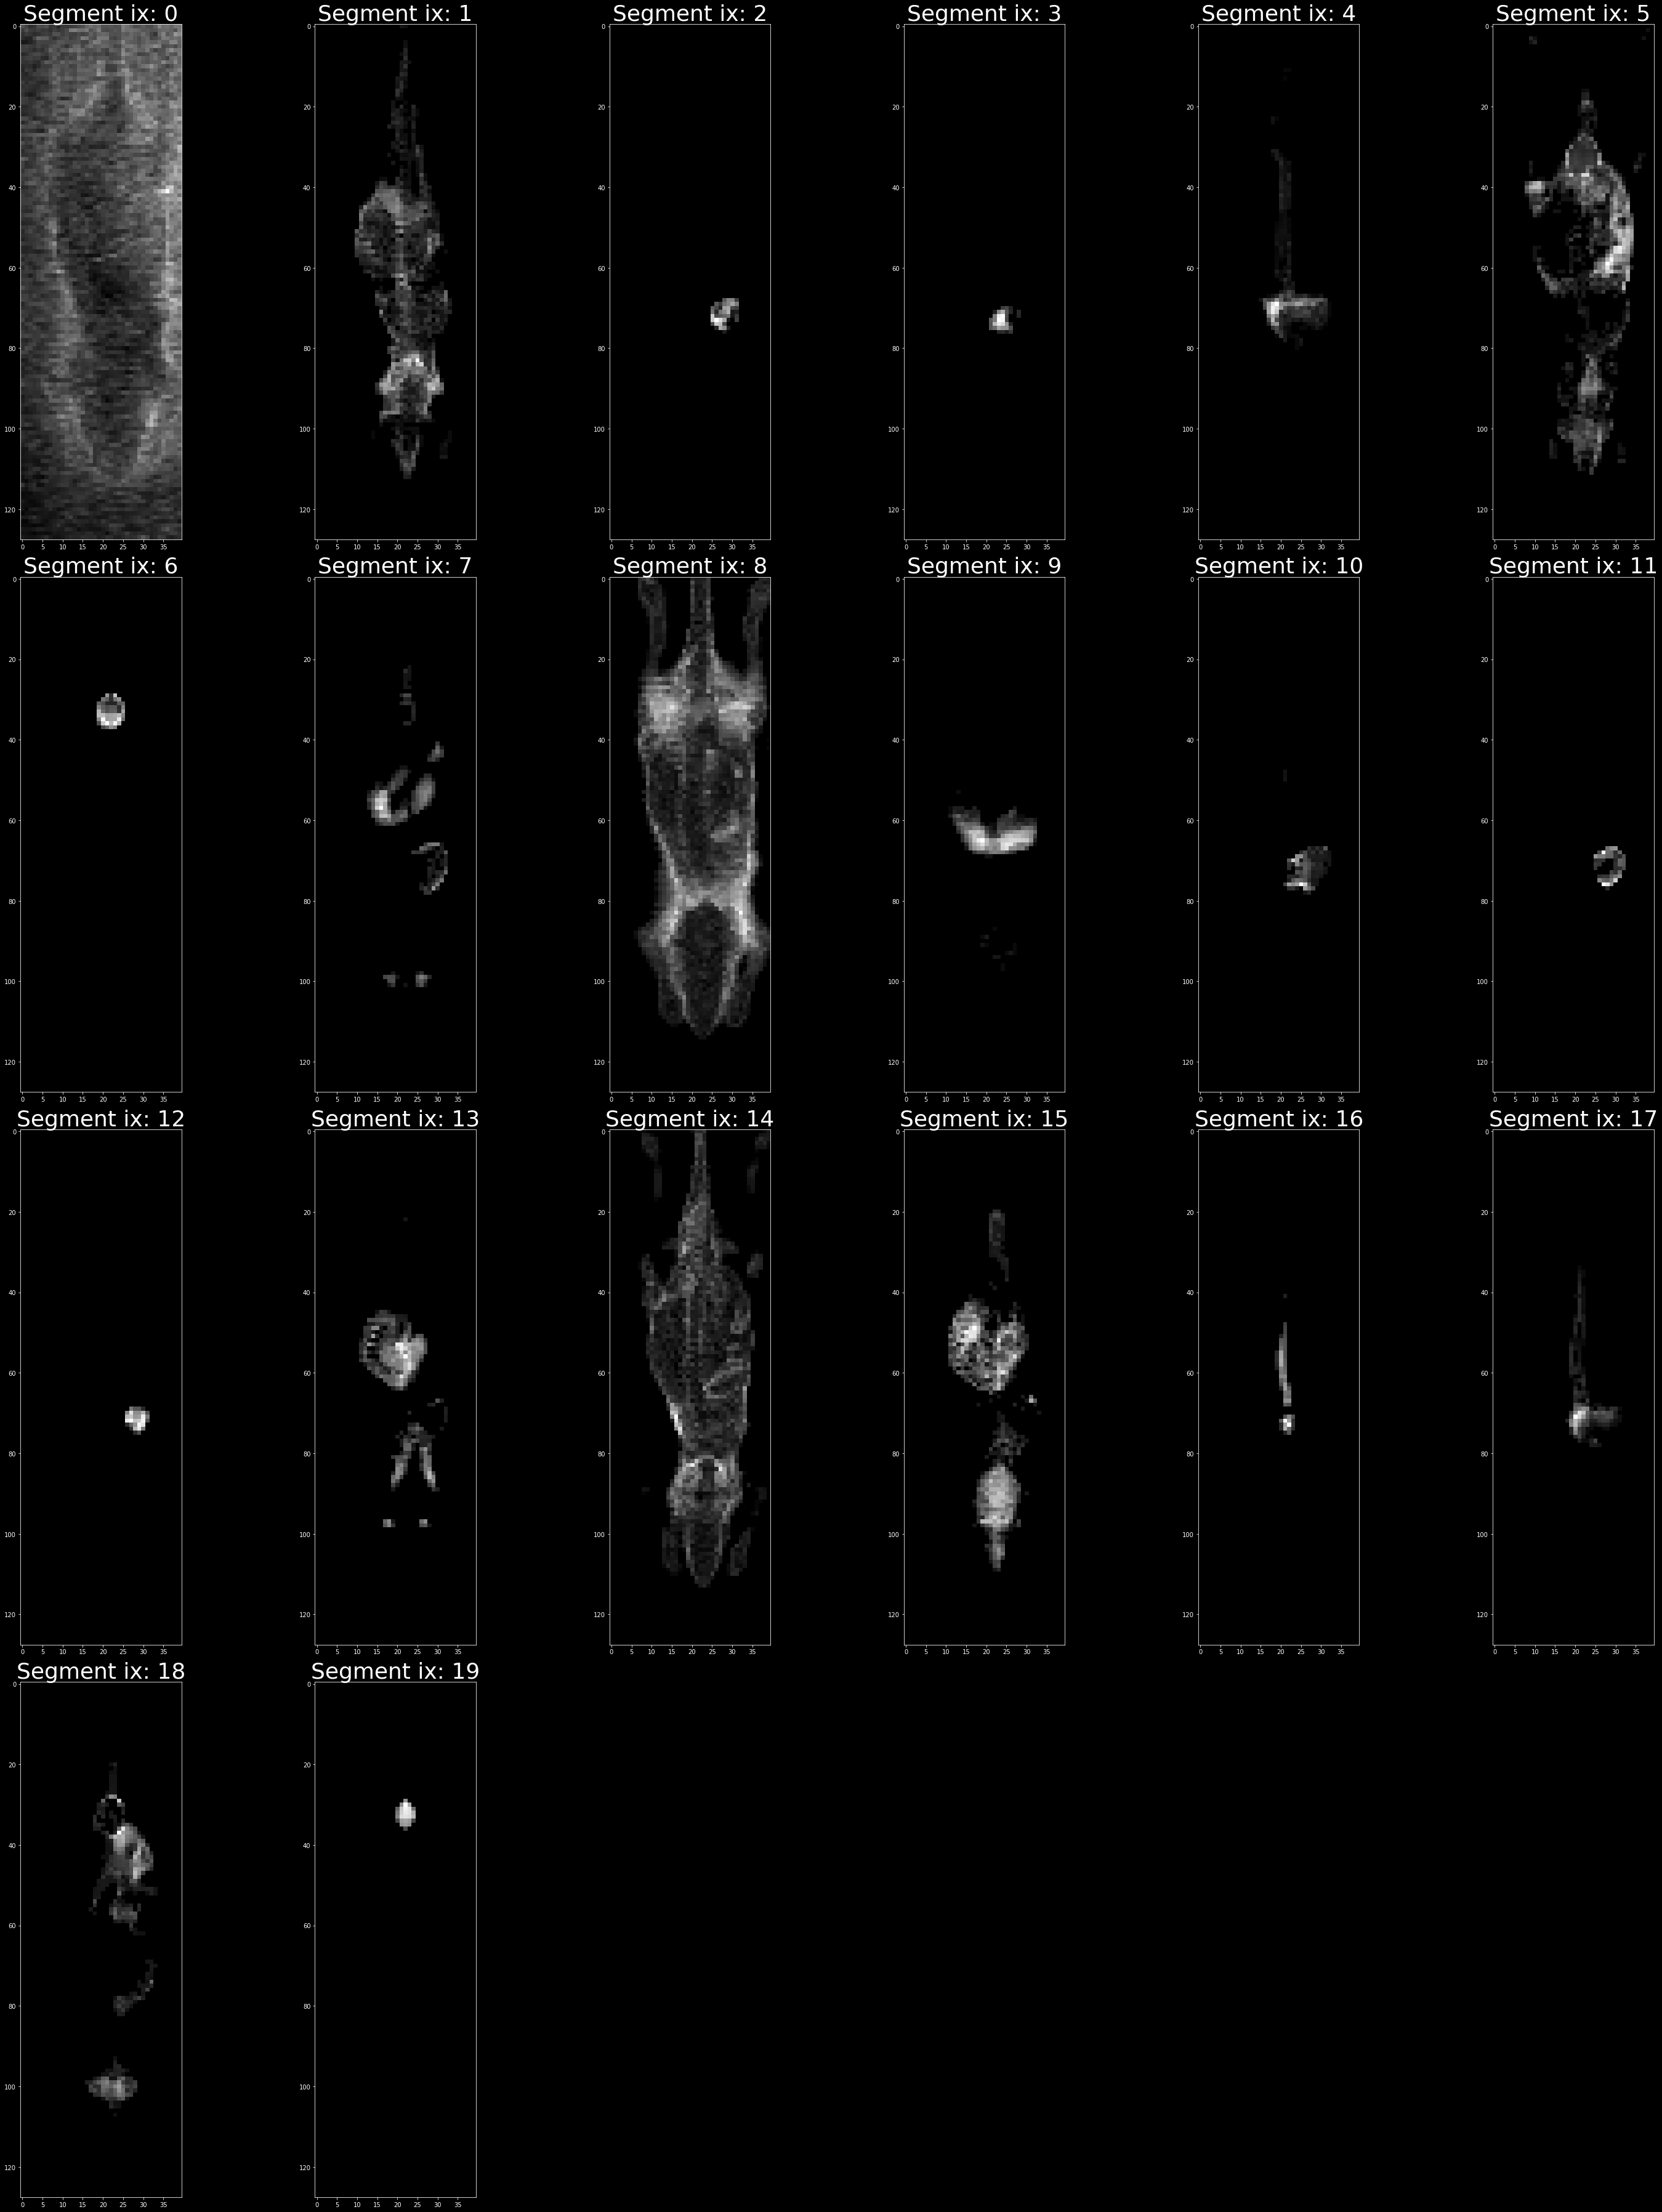

In [242]:
# done with original image data
orig_rois = apply_masks(masks,roi)
plot_segments(orig_rois)
new_rois = orig_rois.copy()

In [243]:
# # if need to combine segments
# my_img.unload_image()
# new_rois = combine_segments(new_rois,(3,4))
# plot_segments(new_rois)

#### plot total intensity of each segment

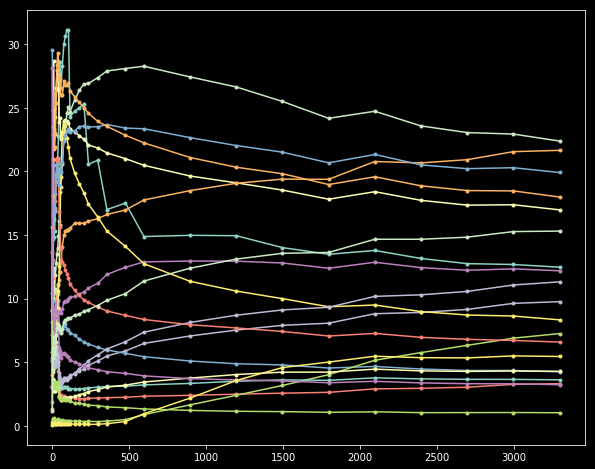

In [248]:
n_start = 2
ts = np.cumsum([0]+list(my_img.params.frame_duration[n_start:-1]))

intensity_curves  = [mroi.reshape(Ws[0]*Ws[1]*Ws[2],Ns[-1]).sum(axis=0) for mroi in new_rois]
df = pd.DataFrame(data=np.stack(intensity_curves).T)
df.iloc[n_start:,:].plot(x=ts,figsize=(10, 8),marker='.',legend=False)

#### Pick some clusters

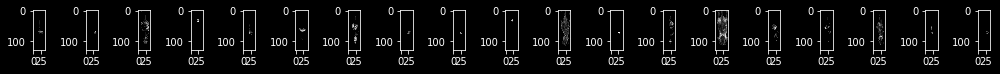

In [204]:
ixs = list(range(1,20))#[1,2,3,4,5,6,7,8,9]
# ixs = list(range(1,options['nclusters']))
fig = plt.figure(figsize=(14,12))
axes = []
for k,ix in enumerate(ixs):
    ax = plt.subplot(1,len(ixs),k+1)
    axes.append(ax)
    disp_segment(new_rois[ix], ax=axes[-1],view_ax='y')
plt.tight_layout()
plt.show()


#### Get cluster data as df    

In [205]:
# since we lose a row in diff step,
# just use first N rows of df


# dont use first few rows with no tracer
N = 40
npts = N-n_start-1
X = df.iloc[n_start:-1,:]
X_dot = df.diff()[n_start+1:]

In [214]:
X_dot.shape,X.shape

((37, 20), (37, 20))

#### Get subdf with just the ixs of the clusters we want to analyze

In [207]:
tX = X[ixs].reset_index(drop=True)
tX_dot = X_dot[ixs].reset_index(drop=True)
frame_durations = my_img.params.frame_duration[n_start:-1]
tX_dot = tX_dot.div(frame_durations,axis=0)   # divide out frame duration
t__ = np.zeros(frame_durations.shape)
t__[1:] = frame_durations[:-1]
t_span = np.cumsum(t__)
tXmat = tX.as_matrix()


#### Run SINDy

In [230]:
n,nVars = tX.shape

# variable labeling
cols = ['x{}'.format(i+1) for i in ixs]
tX.columns = cols
dot_labels = pd.Index([s + ' [dot]' for s in cols])

# SINDy params
polyorder = 1
lam = 0.000001
usesine = 0

# generate data
Theta = pd.DataFrame()
Theta = poolData(tX,nVars, polyorder, usesine)

# run SINDy
Xhat_df = sparsifyDynamics(Theta,tX_dot,lam)
Xhat_df = Xhat_df.set_index(dot_labels)
Xhat_df

/Users/frankenstein/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


,0,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20
x2dot,0.0,-0.348233,-0.479576,0.193398,0.212372,0.396410,-0.026395,-0.048741,-0.213579,-0.864613,-0.176638,0.059999,0.442421,-0.408542,-0.092549,0.073350,-0.167689,0.093399,0.039446,1.031470
x3dot,0.0,-0.056783,-0.721145,0.159468,0.261001,0.263147,-0.039433,-0.096064,-0.279424,-0.394875,-0.157109,0.003256,0.339679,-0.239776,-0.036048,0.036751,-0.032041,0.072843,0.148037,0.900574
x4dot,0.0,0.072807,-0.157379,0.006469,0.013986,0.175003,-0.019901,0.048893,-0.619473,-0.379473,0.088269,-0.046831,0.524330,-0.294799,0.050144,0.100436,-0.100026,-0.054338,0.145903,0.216913
x5dot,0.0,-0.000567,-0.015374,0.008773,0.003704,0.019168,-0.002534,0.004077,-0.020228,-0.058849,0.000139,-0.004610,0.041050,-0.029085,-0.000525,0.001400,-0.007315,0.001211,0.016734,0.025666
x6dot,0.0,-0.265183,-0.440829,0.185562,0.160838,0.262982,-0.023277,-0.051659,-0.079011,-0.727495,-0.199496,0.020582,0.366995,-0.317131,-0.095738,0.019736,-0.187603,0.137455,-0.051865,0.956499
x7dot,0.0,0.026262,-0.257186,-0.083445,0.043541,0.061391,-0.029690,0.147276,-0.750081,0.060888,0.185150,-0.119462,0.531423,-0.291903,0.123528,0.154281,-0.009259,-0.126811,0.087114,0.064609
x8dot,0.0,0.179187,-0.956453,0.370076,0.190966,0.775003,-0.104312,0.008075,-0.967514,-1.577079,-0.151280,-0.123320,1.345742,-0.792457,0.047047,0.230487,-0.447526,-0.128748,0.196425,1.332530
x9dot,0.0,-0.076626,-0.279780,0.101788,0.087352,0.196435,-0.018170,-0.035125,-0.248811,-0.368298,-0.062375,0.020275,0.278269,-0.214075,-0.024093,0.052023,-0.097902,0.020820,0.040170,0.500219
x10dot,0.0,-0.112123,-0.341449,0.124142,0.124633,0.195750,-0.021753,-0.021829,-0.135936,-0.512973,-0.119826,-0.017704,0.307787,-0.241129,-0.042465,0.005996,-0.118335,0.084557,0.038871,0.678154
x11dot,0.0,0.000337,0.019293,-0.000773,-0.008409,0.010261,0.001164,0.001672,-0.025470,-0.004472,0.009920,0.013005,0.010699,-0.010448,0.001864,0.015520,-0.004496,-0.019682,-0.005613,-0.018523


## Test recovered dynamics

In [231]:
# find dynamic_fn: x -> x_dot
dynamic_fn = lambda x,t: np.squeeze(np.matmul(
        Xhat_df.as_matrix(),
        poolData(pd.DataFrame(x).T,nVars, polyorder, usesine).values.T
))


# how to choose x0?
x0 = tX.iloc[0].values

# reconstruct x(t_span)
if polyorder == 1:
    X_s = optimal_linear_trajectory(tXmat,Xhat_df,t_span)
else:
    X_s = odeint(dynamic_fn,x0,t_span)


In [232]:
# X_s.shape, tX.shape
# X_s = np.zeros(tX.shape)
# X_s += ode()


###### Plot phase curves for simulated 

In [233]:
# xa,xb = 0,2
# scale_trajectory = False

# combs = list(itertools.combinations(list(range(len(ixs))),2))
# plt.figure(figsize=(12,14))
# for k,(xa,xb) in enumerate(combs):

#     xsa,xsb = X_s[:,xa],X_s[:,xb]
#     txa,txb = tXmat[:,xa],tXmat[:,xb]
# #     if scale_trajectory:
# #         xsa = xsa*(xsa.dot(txa)/np.linalg.norm(xsa))
# #         xsb = xsb*(xsb.dot(txb)/np.linalg.norm(xsb))

#     ax = plt.subplot(np.ceil(len(combs)/2),2,k+1)    
#     ax.plot(xsa,xsb)
#     ax.set_title('x{} vs x{}'.format(xb,xa))
#     plt.plot(txa,txb)
#     plt.legend(['simulated','original'])
# plt.show()

###### Compare single var over time

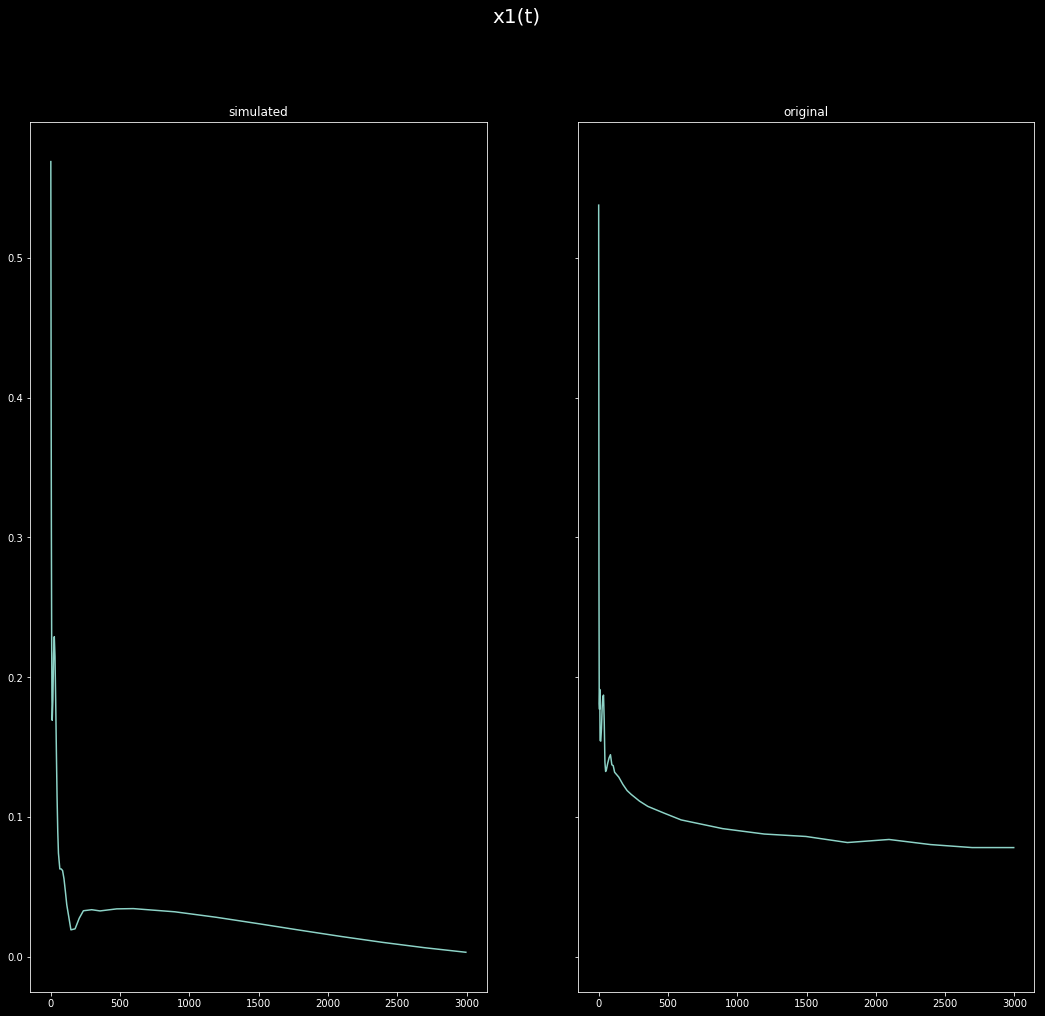

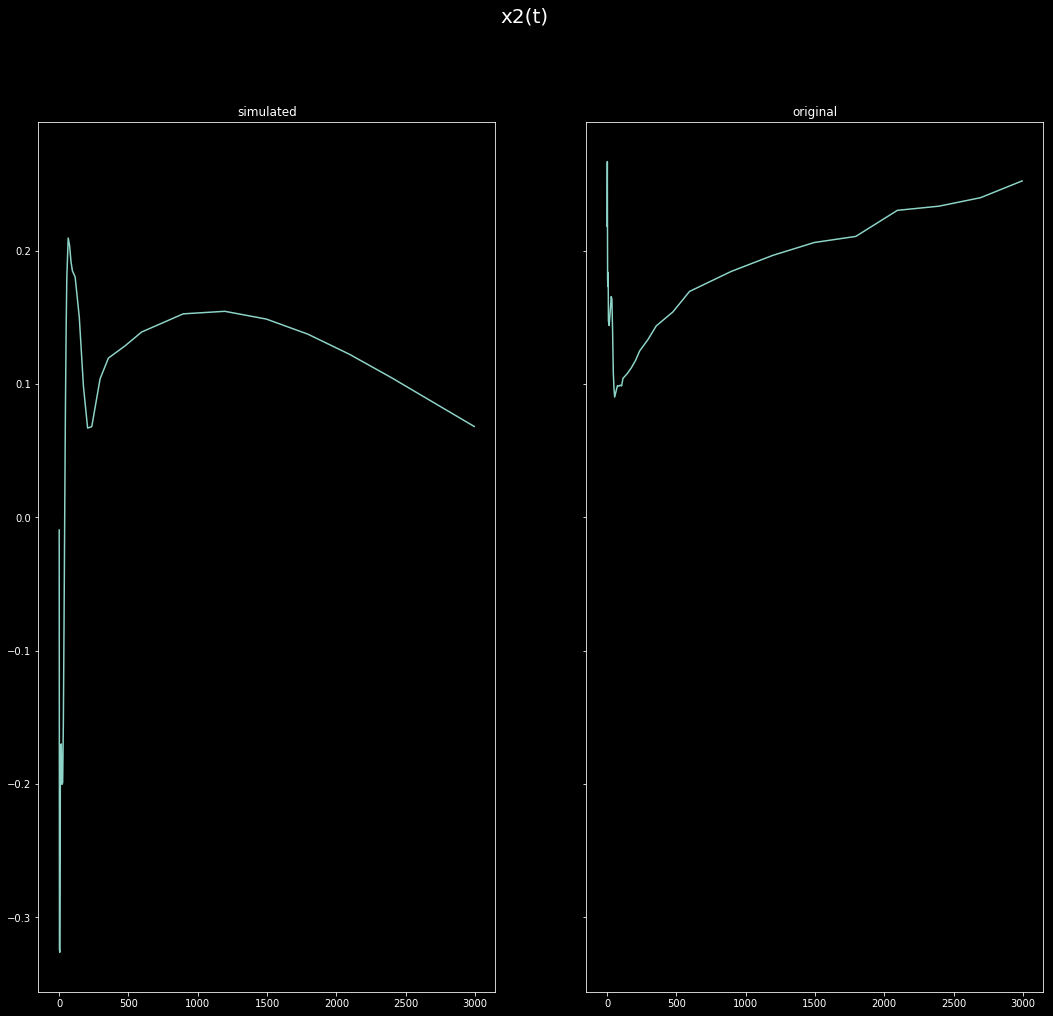

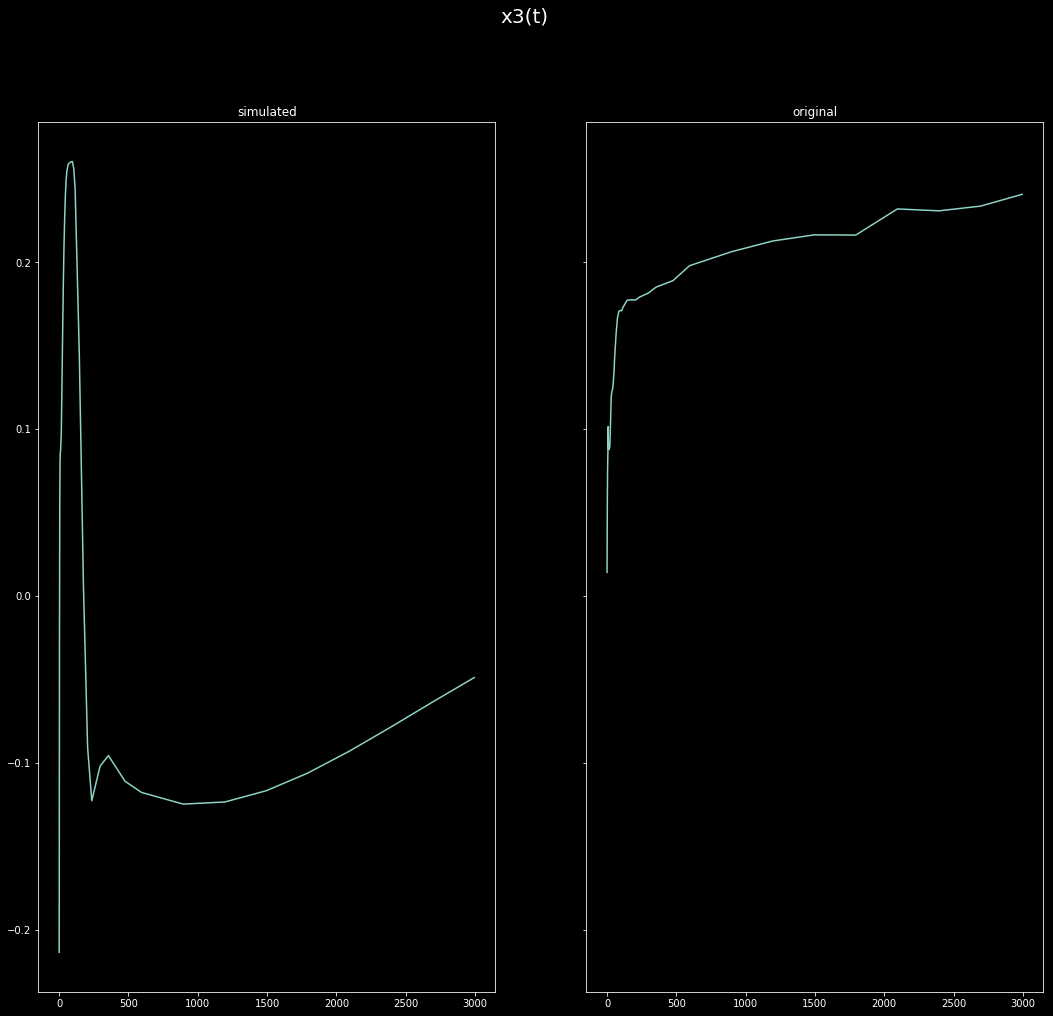

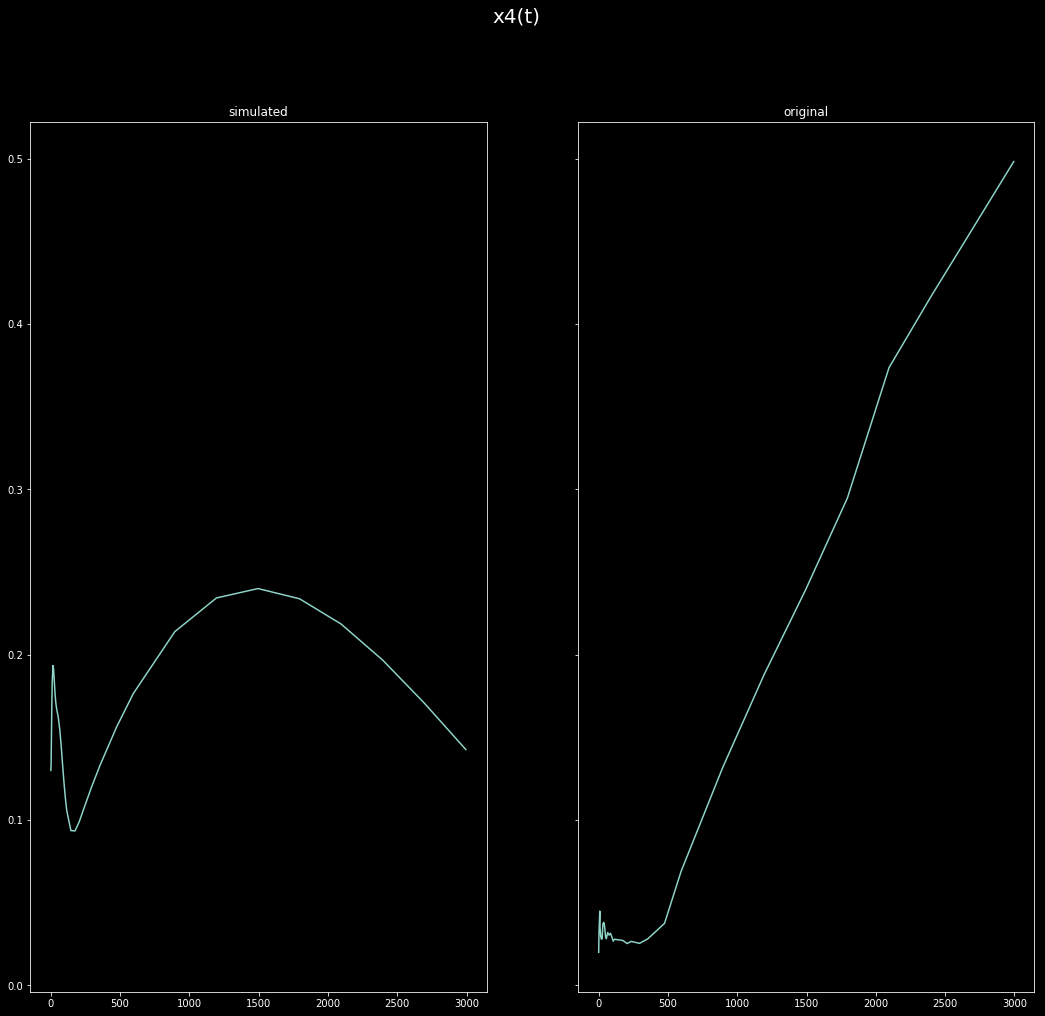

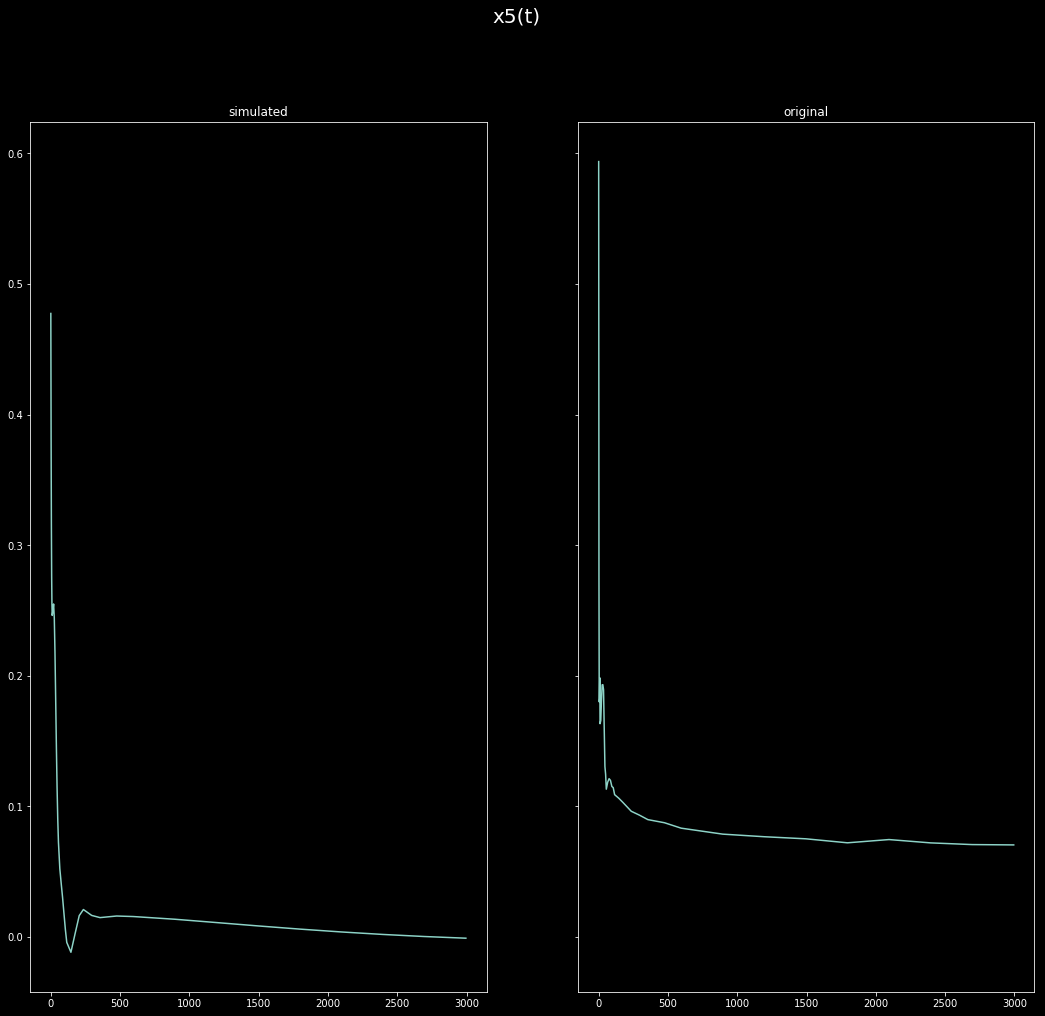

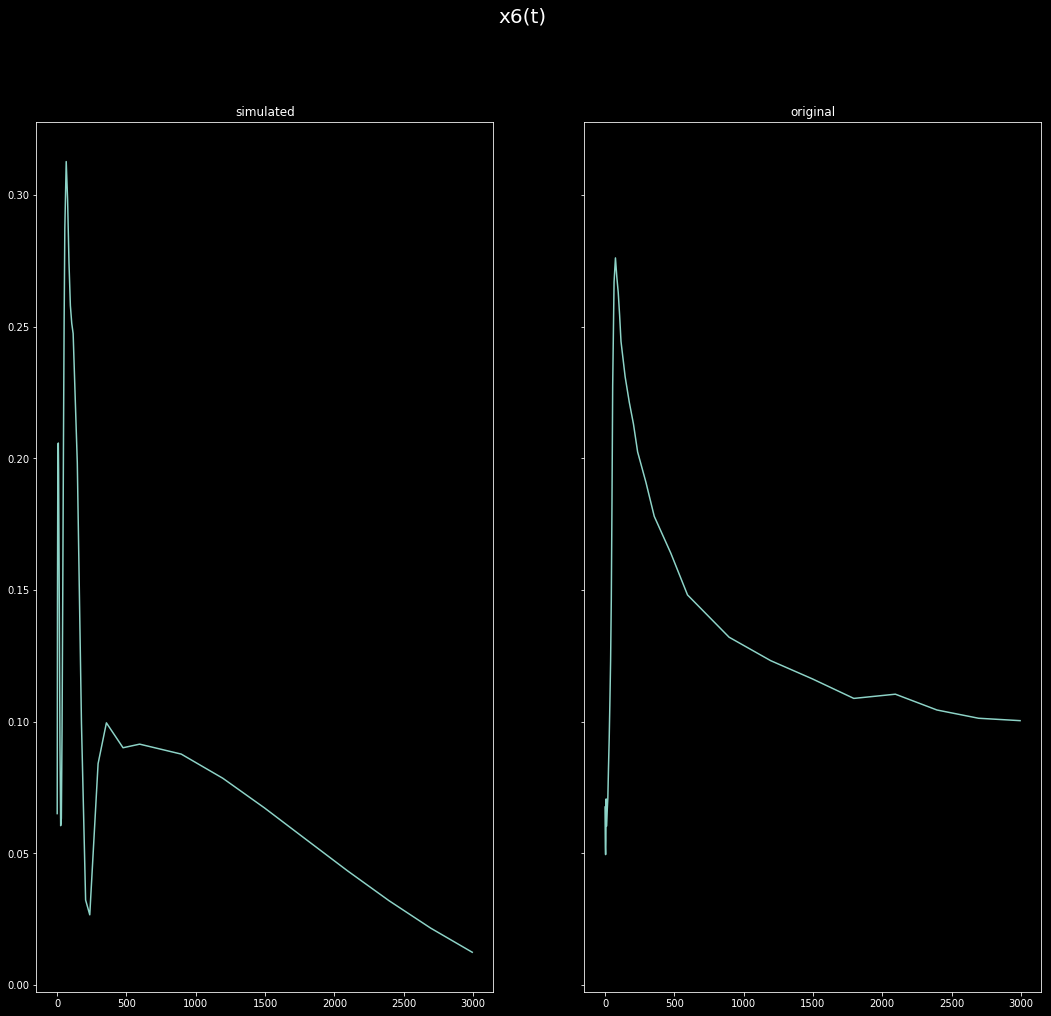

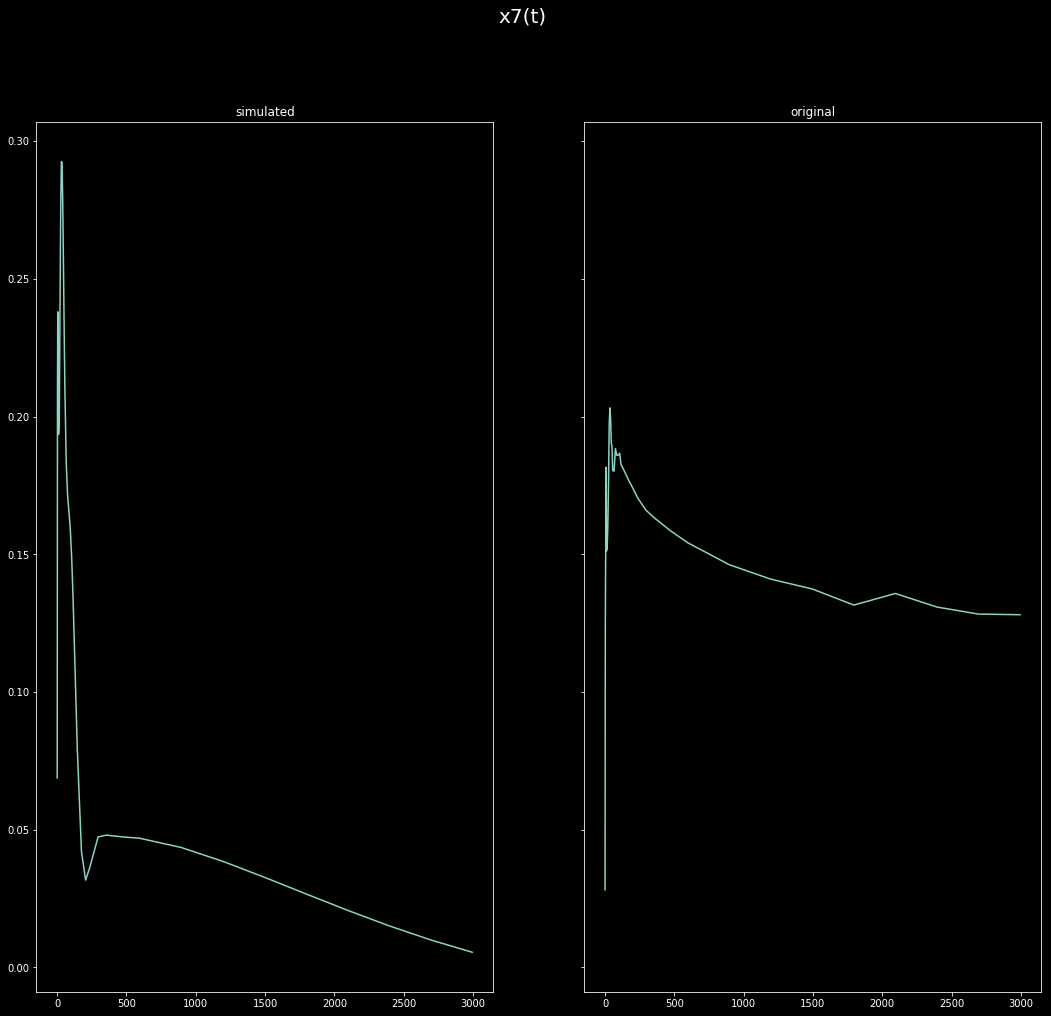

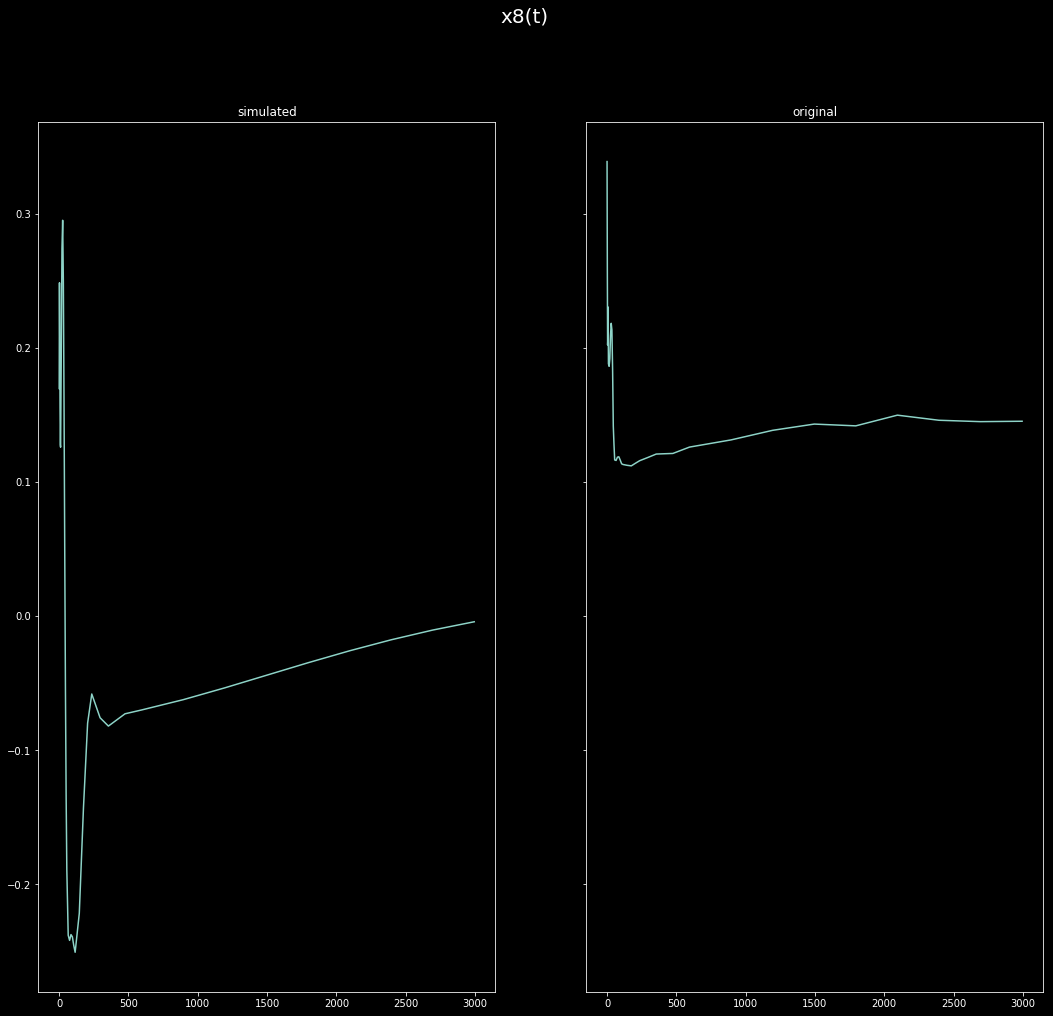

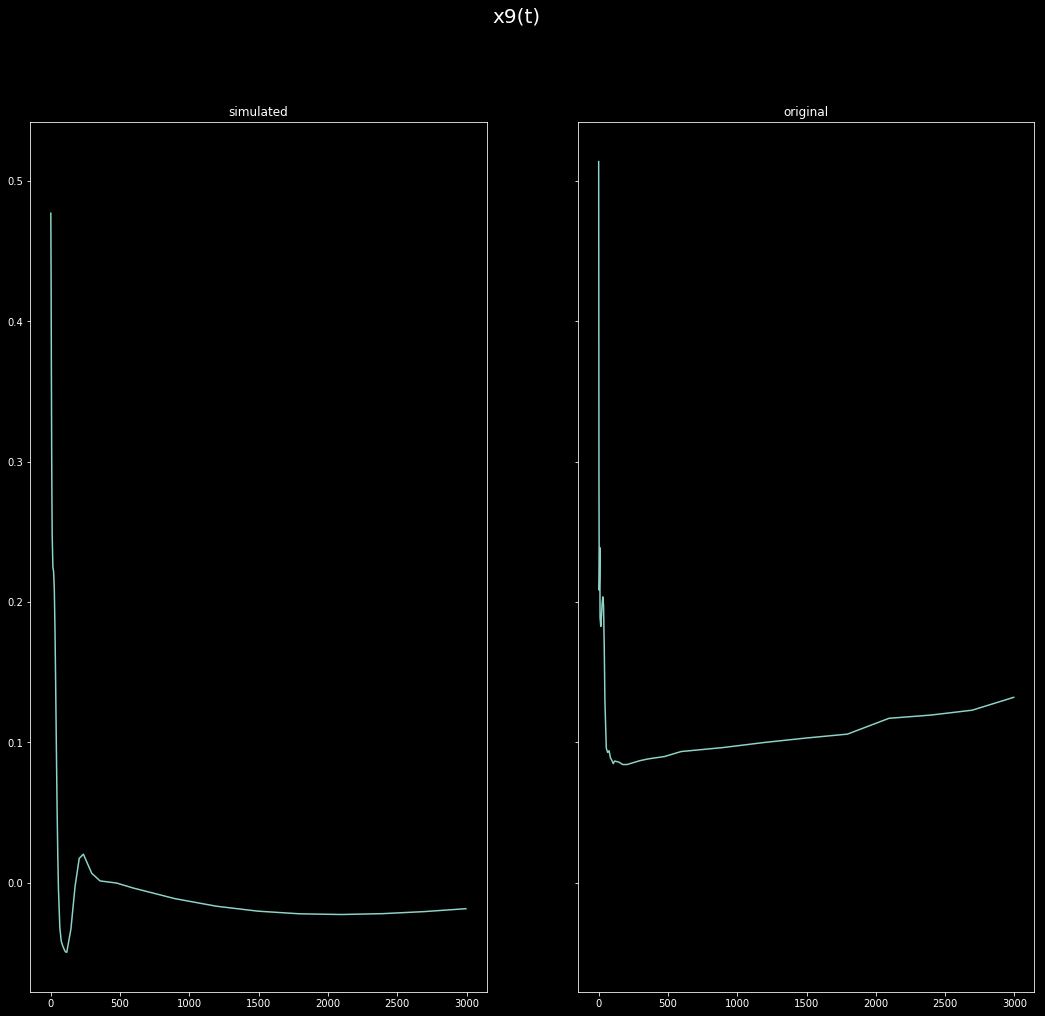

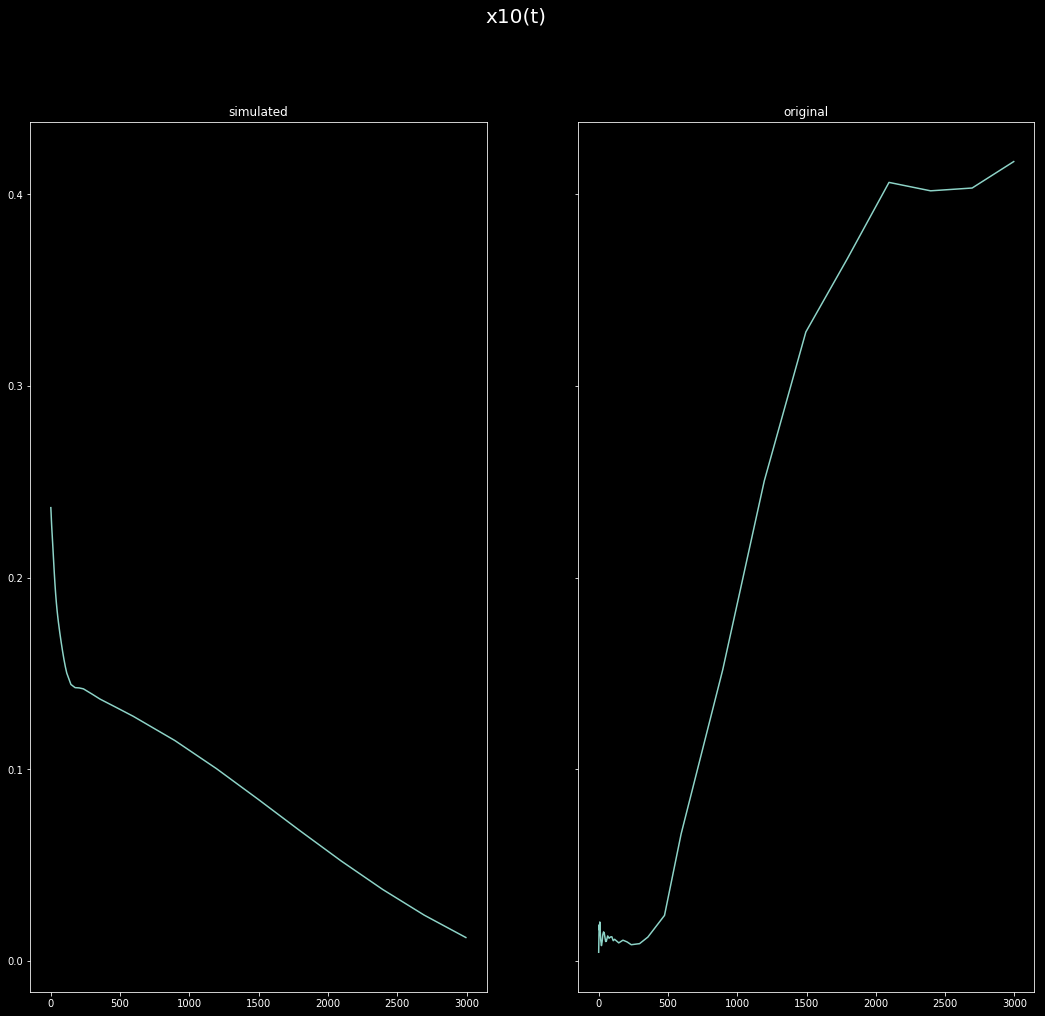

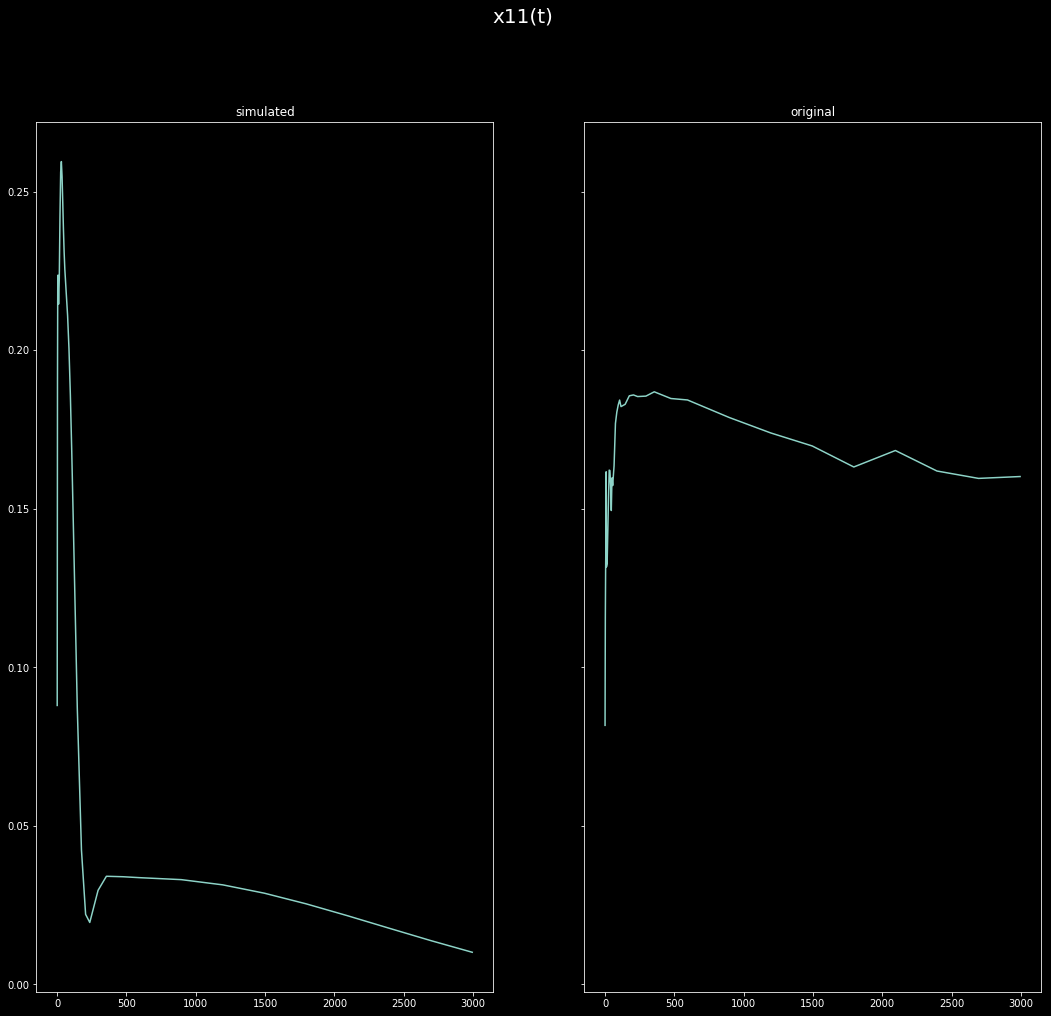

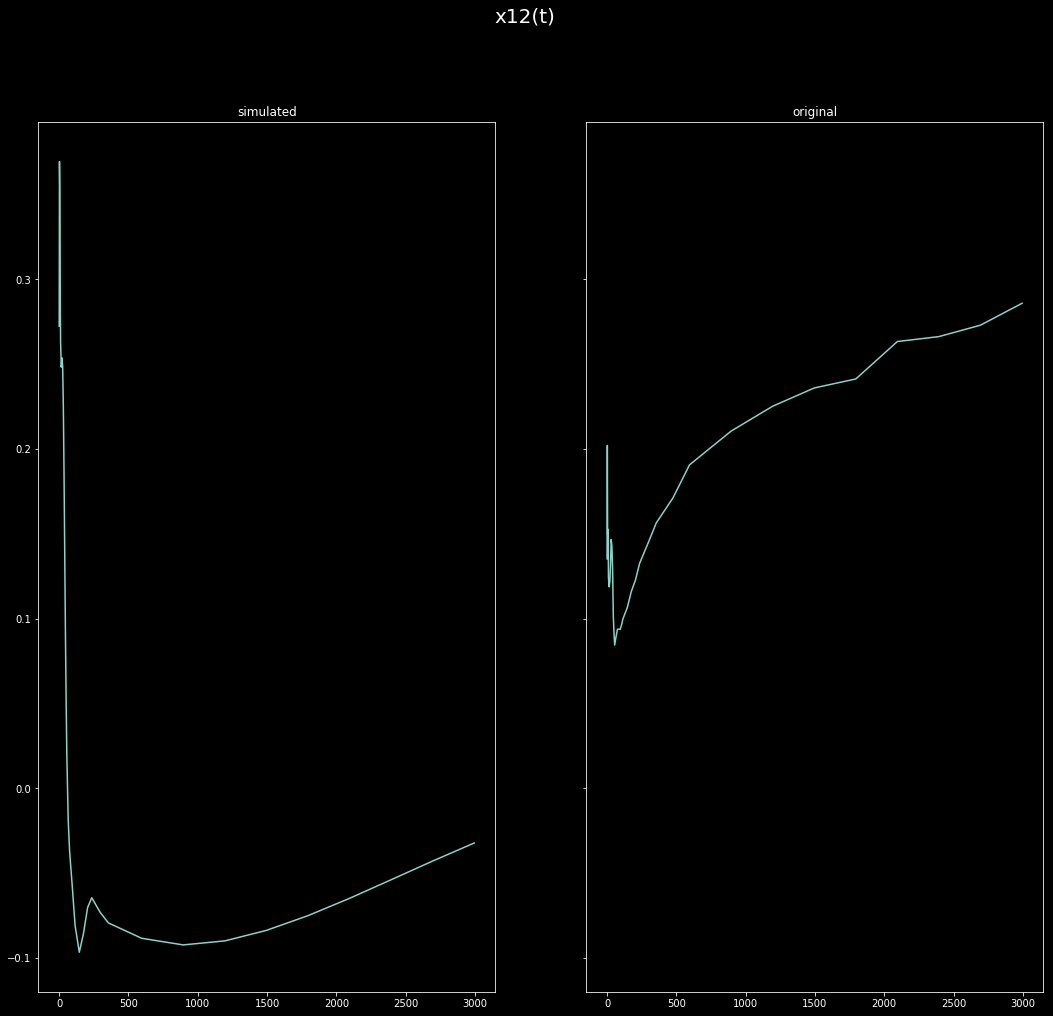

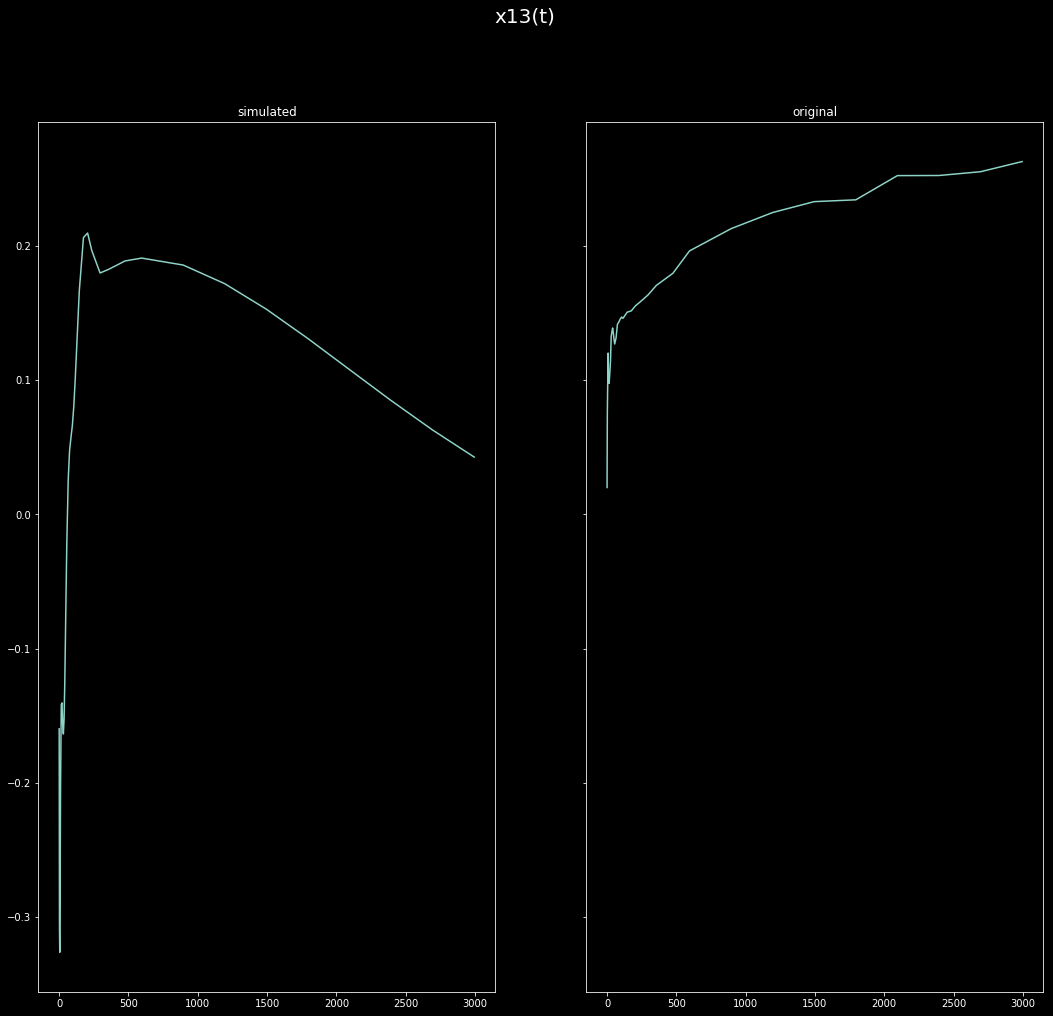

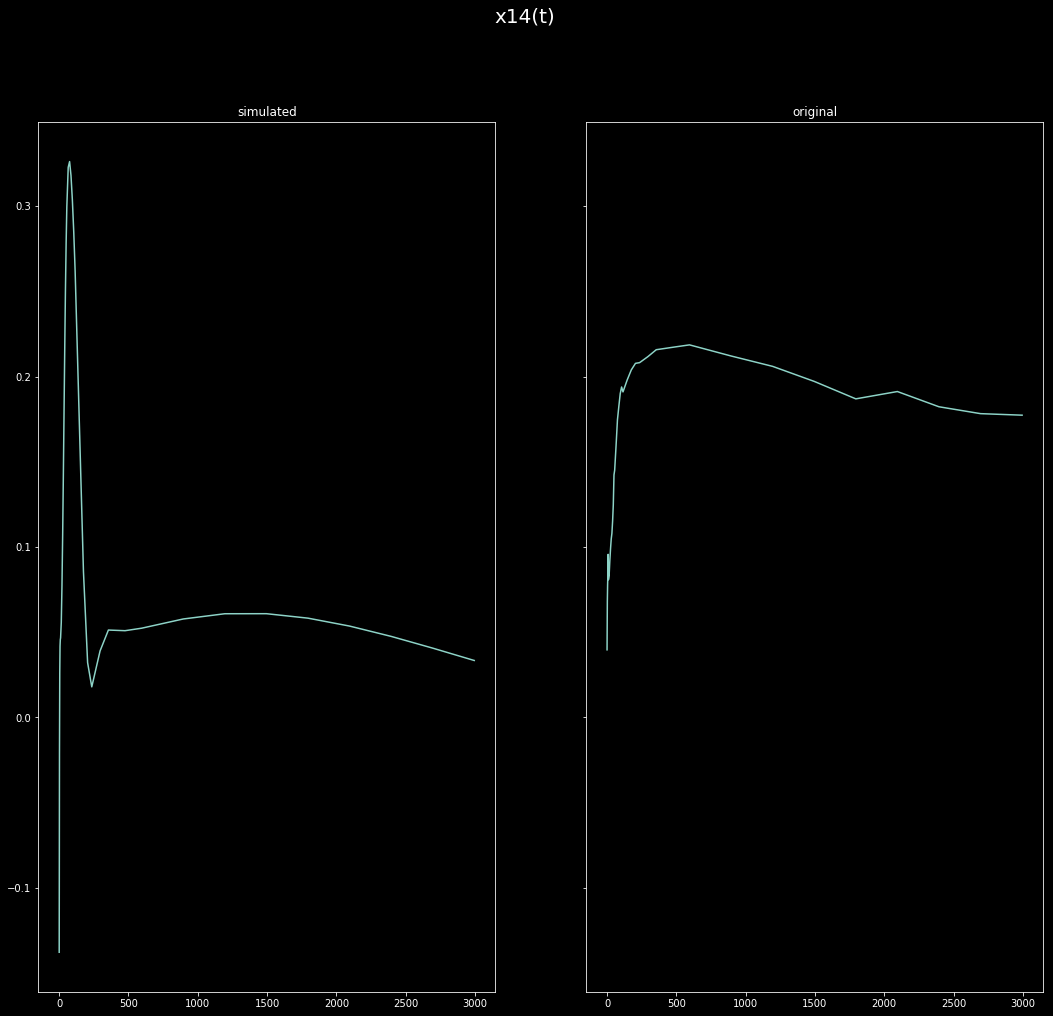

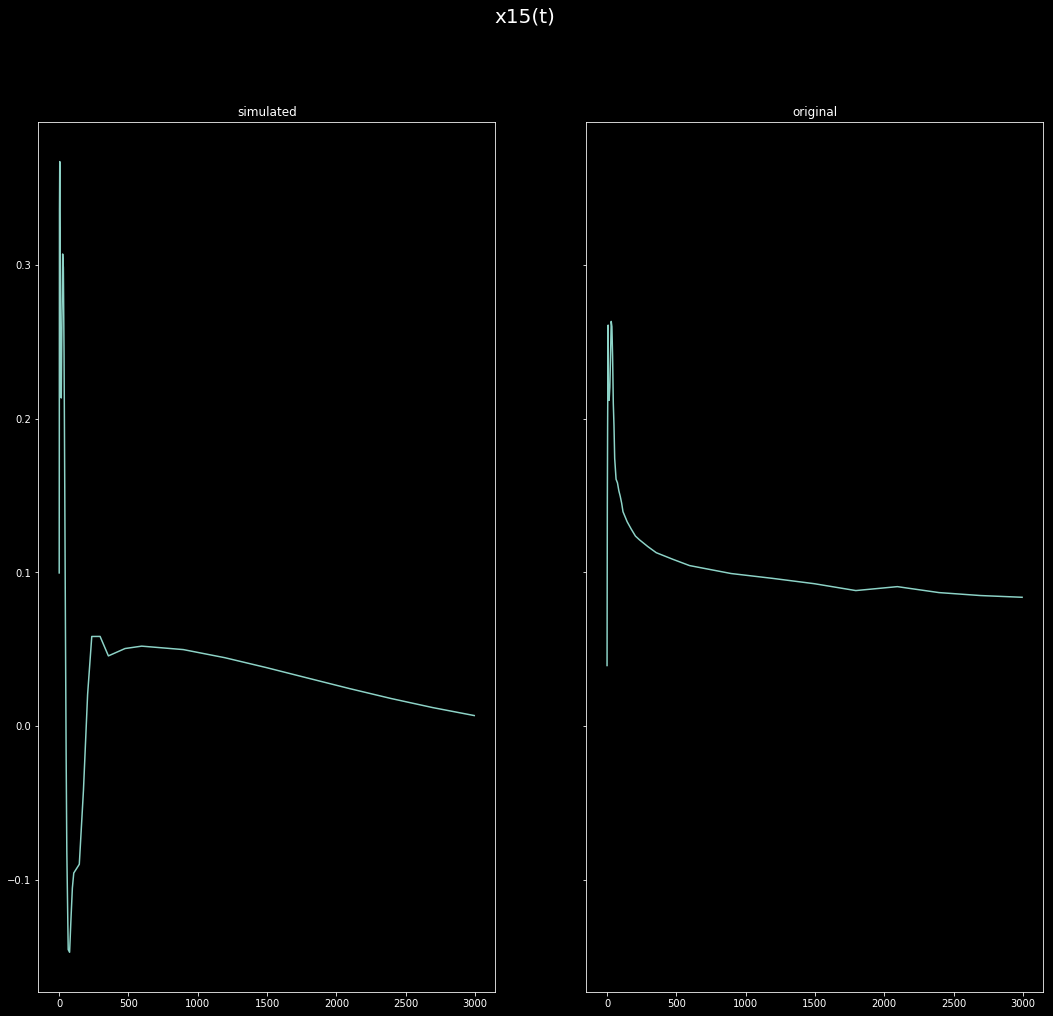

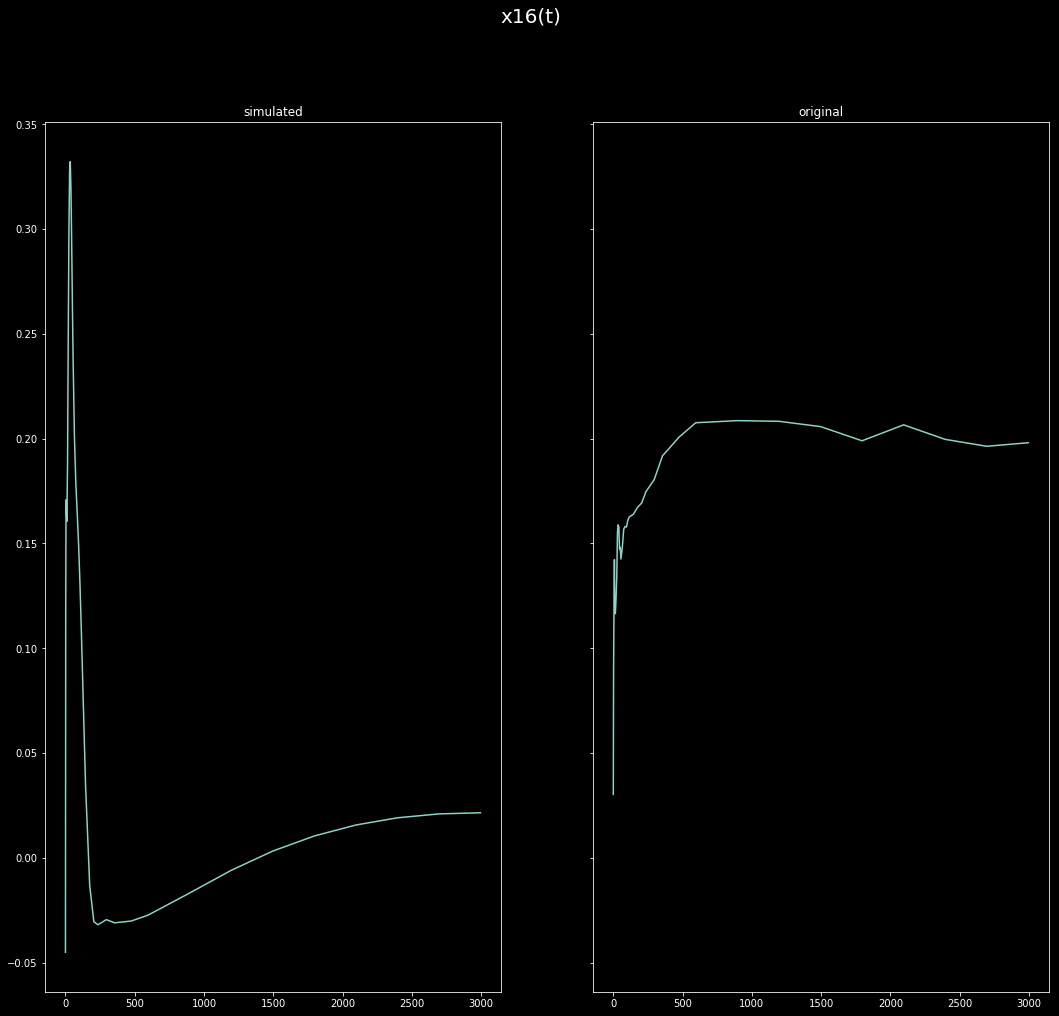

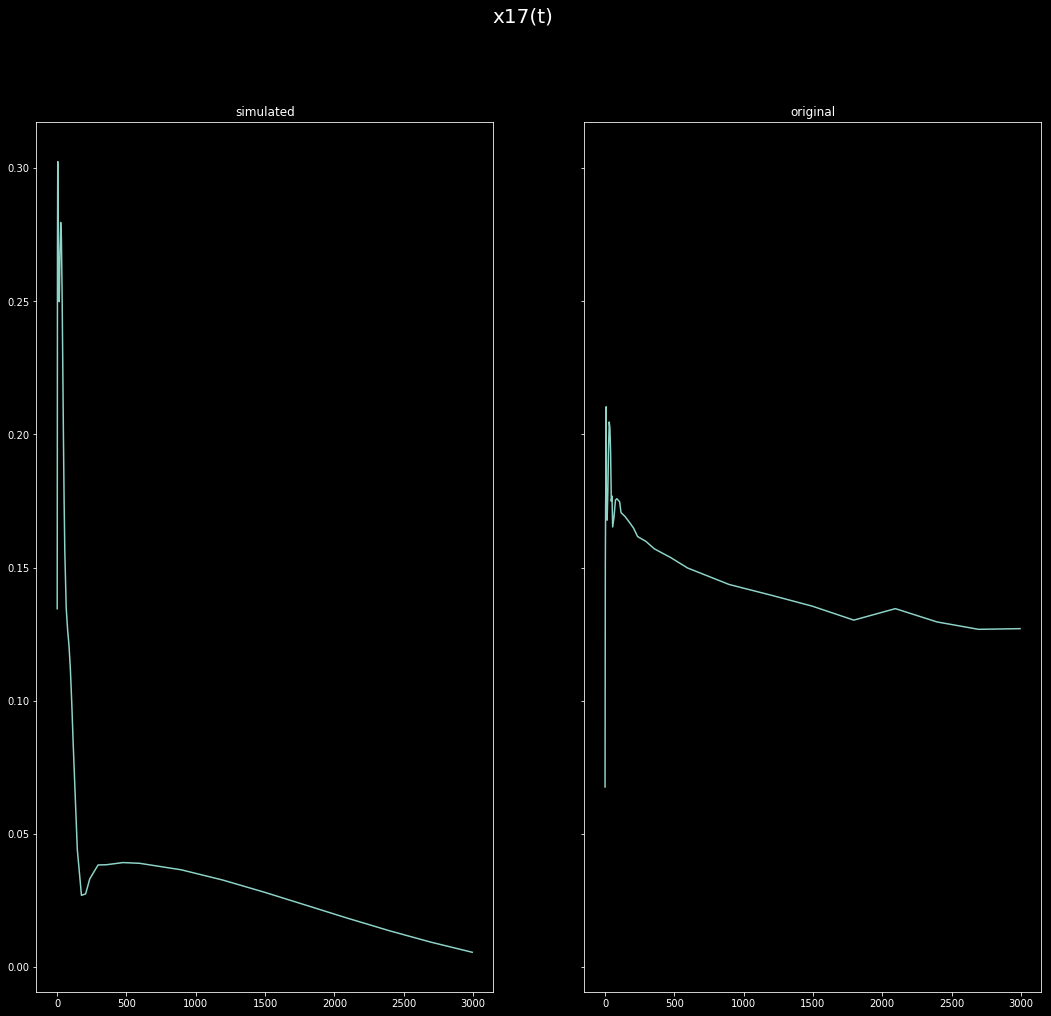

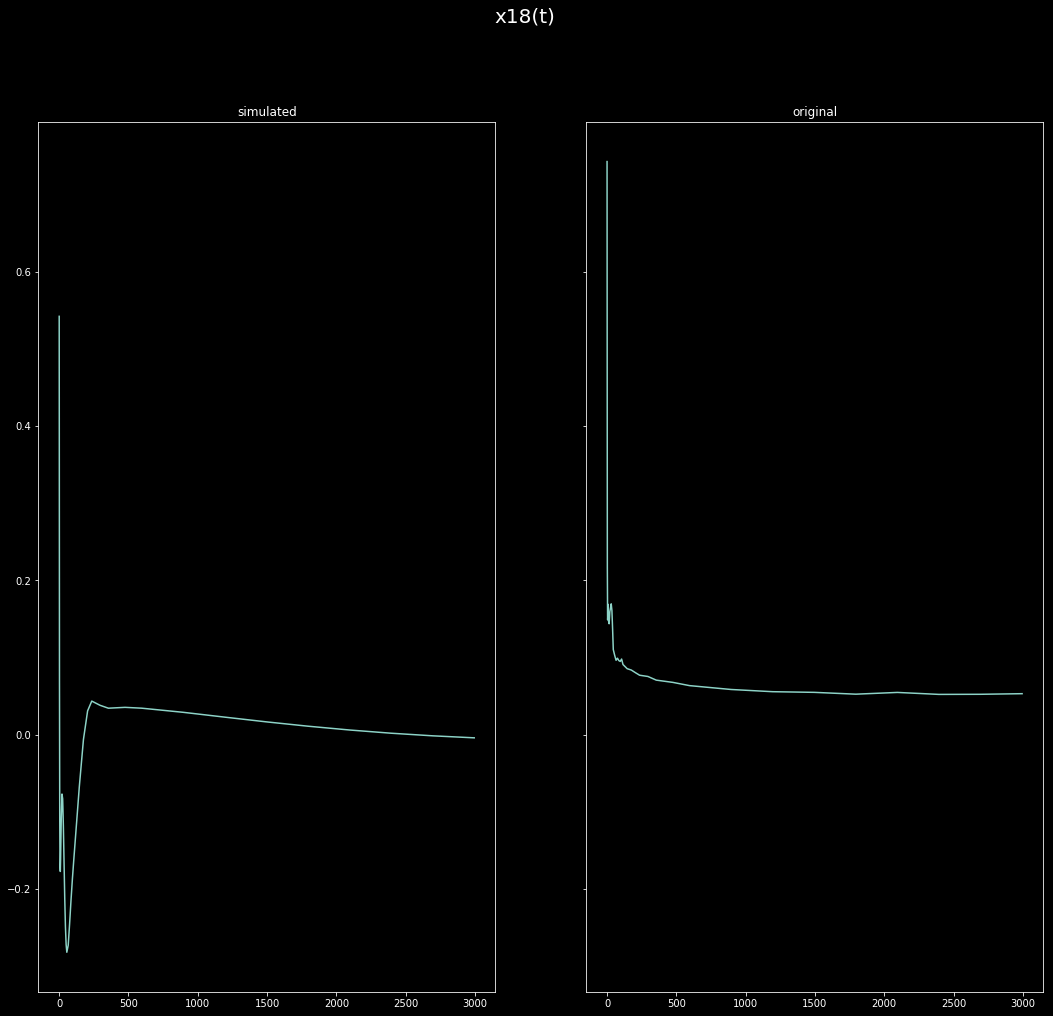

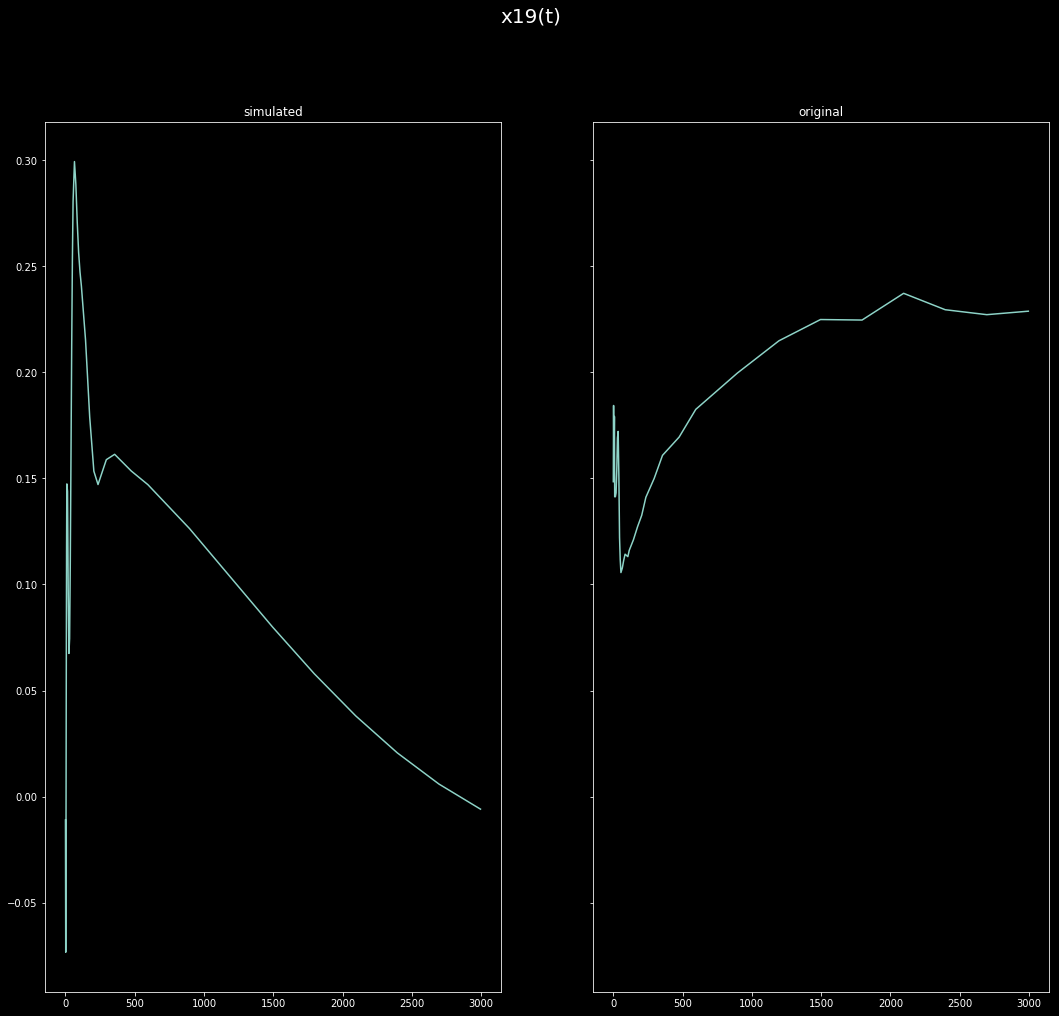

In [234]:
scale_trajectory = True

for x in range(len(ixs)):
    begin_off = 0

    fulldf = pd.concat([pd.DataFrame(X_s),tX],axis=1)

    plt.figure(figsize=(12, 8))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 16), sharey=True)
    sim_arr = X_s[begin_off:,x]
    orig_arr = tXmat[begin_off:,x]
    if scale_trajectory:
        sim_arr = sim_arr*(orig_arr.dot(sim_arr)/np.linalg.norm(sim_arr))
    
    ax1.plot(t_span[begin_off:],sim_arr/np.linalg.norm(sim_arr))
    ax2.plot(t_span[begin_off:],orig_arr/np.linalg.norm(orig_arr))
    ax1.set_title('simulated')
    ax2.set_title('original')
    f.suptitle('x{}(t)'.format(ixs[x]),fontsize=20)
    plt.show()


#### Try modeling heart vs other clusters

In [60]:
heart_ixs = [3,6,19]
noise_ixs = [0]
heart_df = df[heart_ixs]
body_df = df.drop(heart_ixs+noise_ixs,axis=1)

# body and heart into one df
X_df = pd.concat([heart_df.sum(axis=1),body_df.sum(axis=1)],axis=1)

# Xdot and select starting point
N = 40
n_start = 3
npts = N-n_start-1
tX = X_df[n_start:-1]
tX_dot = X_df.diff()[n_start+1:]

tX = tX.reset_index(drop=True)
tX = tX_dot.reset_index(drop=True)


# prep SINDy
n,nVars = tX.shape
cols = ['x{}'.format(i+1) for i in range(nVars)]
tX.columns = cols
dot_labels = pd.Index([s + 'dot' for s in cols])
polyorder = 1
lam = 0.001
usesine = 0
Theta = pd.DataFrame()
Theta = poolData(tX,nVars, polyorder, usesine)

# run SINDy
Xhat_df = sparsifyDynamics(Theta,tX_dot,lam)
Xhat_df = Xhat_df.set_index(dot_labels)
print(Xhat_df.head())

# test recovered dynamics
dynamic_fn = lambda x,t: np.squeeze(np.matmul(
        Xhat_df.as_matrix(),
        poolData(pd.DataFrame(x).T,nVars, polyorder, usesine).values.T
))
t_span = np.cumsum(frame_durations)
x0 = tX.iloc[0].values
dynamic_fn(x0,3)
X_s = odeint(dynamic_fn,x0,t_span)

# plot state space
xa,xb = 0,1
plt.plot(X_s[:,xa],X_s[:,xb])
tXmat = tX.as_matrix()
plt.plot(tXmat[:,xa],tXmat[:,xb])
plt.legend(['simulated','original'])
plt.show()



KeyError: '[19] not in index'

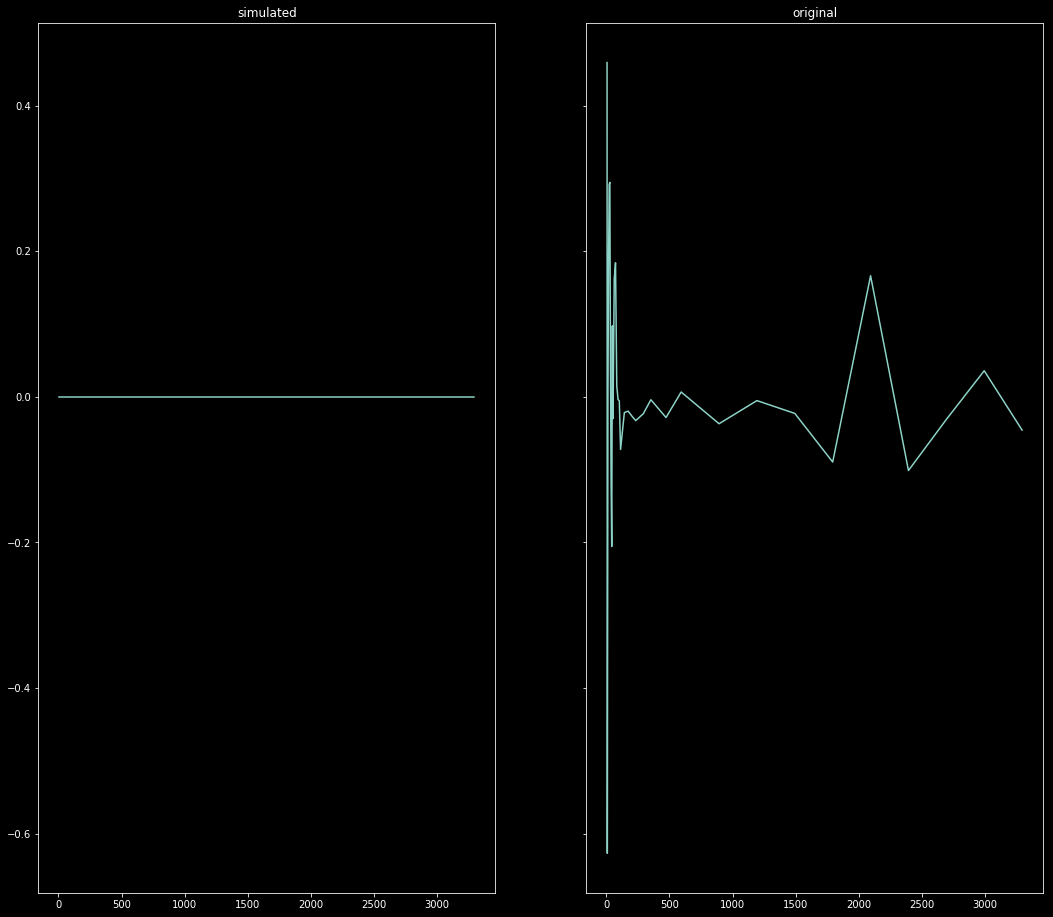

In [82]:
x = 1
begin_off = 2

fulldf = pd.concat([pd.DataFrame(X_s),tX],axis=1)

plt.figure(figsize=(12, 8))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 16), sharey=True)
sim_arr = X_s[begin_off:,x]
ax1.plot(t_span[begin_off:],sim_arr/np.linalg.norm(sim_arr))
orig_arr = tXmat[begin_off:,x]
ax2.plot(t_span[begin_off:],orig_arr/np.linalg.norm(orig_arr))
ax1.set_title('simulated')
ax2.set_title('original')
plt.show()

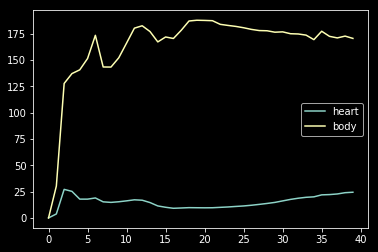

In [83]:
heart_df.sum(axis=1).plot()
body_df.sum(axis=1).plot()
plt.legend(['heart','body'])

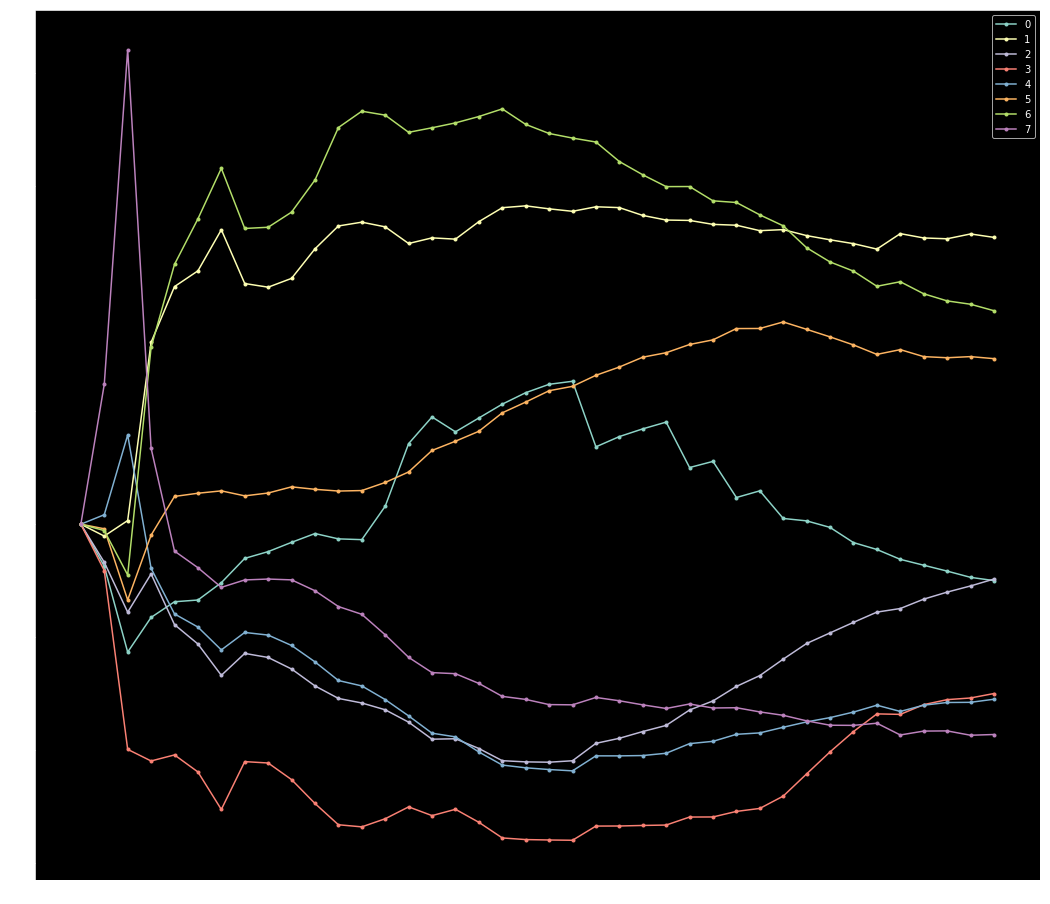

In [25]:
# subtract mean at each time point from corresponding intensities
sdf = df.subtract(df.mean(axis=1),axis=0)
sdf.plot(figsize=(18, 16),marker='.')

In [49]:
x = tX.as_matrix().flatten()

In [53]:
type(x.reshape(36,2))

numpy.ndarray

In [55]:
x.reshape((72,1))

array([[ 1.21304564],
       [ 5.58467786],
       [ 2.62456014],
       [ 8.26034559],
       [ 5.18753694],
       [ 9.3742444 ],
       [ 8.03919971],
       [ 7.63737466],
       [13.45987446],
       [ 3.3493414 ],
       [16.48789032],
       [ 2.05616163],
       [18.07733442],
       [ 1.74479736],
       [19.06775218],
       [ 1.62388916],
       [19.6061845 ],
       [ 1.42789642],
       [19.95638351],
       [ 1.3486319 ],
       [20.21179679],
       [ 1.25337317],
       [20.39669392],
       [ 1.14542588],
       [20.54752499],
       [ 1.09781757],
       [20.57030452],
       [ 0.99898964],
       [20.9312851 ],
       [ 0.94291468],
       [21.11584641],
       [ 0.90761857],
       [21.22196956],
       [ 0.87866111],
       [21.40540255],
       [ 0.84000539],
       [21.40028922],
       [ 0.84110179],
       [21.49831676],
       [ 0.80349081],
       [21.83784536],
       [ 0.76552261],
       [21.98458154],
       [ 0.73500035],
       [22.12795947],
       [ 0

In [33]:
A = Xhat_df.iloc[:,1:3].as_matrix()

In [60]:
Xhat_df.as_matrix()

array([[ 0.        , -0.        ,  0.18837345],
       [ 0.        , -0.        , -0.03339079]])

In [34]:
A

array([[-0.        ,  0.18837345],
       [-0.        , -0.03339079]])

In [35]:
A_2 = np.exp(A*3)

In [36]:
A_2

array([[1.        , 1.75965954],
       [1.        , 0.90468147]])

In [42]:
phi = np.concatenate([A,A_2])#.shape

Estimated Gaussian noise standard deviation = 5.189650340191949e-06
Denoising...


In [236]:
denoised_wavelet.shape

(159, 128, 128, 40)